## Resumo do Projeto

Este projeto, intitulado **"Dormindo como uma Pedra"**, tem como objetivo desenvolver um modelo preditivo utilizando técnicas de aprendizado profundo para analisar e prever a qualidade do sono. A proposta baseia-se na utilização de dados comportamentais e fisiológicos, extraídos do dataset *Health and Sleep Statistics*, para identificar padrões que influenciam o descanso e fornecer recomendações práticas que contribuam para a melhoria da saúde e qualidade de vida dos indivíduos.

Para alcançar esse objetivo, o projeto se estrutura em diversas etapas:
- **Coleta e Pré-processamento dos Dados:** Tratamento de valores ausentes, codificação de variáveis categóricas, normalização e divisão do dataset em conjuntos de treinamento, validação e teste.
- **Análise Exploratória (EDA):** Visualizações e correlações para identificar relações entre as variáveis.
- **Modelagem:** Implementação e treinamento de modelos preditivos, com foco no GBM (usando CatBoost) e na rede MLP, seguidos do ajuste de hiperparâmetros e validação cruzada.
- **Avaliação e Interpretação dos Resultados:** Utilização de métricas como RMSE e R² para mensurar o desempenho dos modelos e identificação dos fatores mais influentes na qualidade do sono.

Em síntese, o projeto busca não apenas prever a qualidade do sono, mas também fornecer insights que possam ser utilizados na prevenção de distúrbios e na promoção de hábitos de vida mais saudáveis.


# Análise Exploratória dos Dados

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

## Análise Explanatoria dos Dados

In [77]:
# Carregando os dados
df = pd.read_csv('../data/Health_Sleep_Statistics.csv')
df

,User ID,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage
0,1,25,f,8,23:00,06:30,8000,2500,medium,healthy,no,no
1,2,34,m,7,00:30,07:00,5000,2200,low,unhealthy,yes,yes
2,3,29,f,9,22:45,06:45,9000,2700,high,healthy,no,no
3,4,41,m,5,01:00,06:30,4000,2100,low,unhealthy,yes,no
4,5,22,f,8,23:30,07:00,10000,2800,high,medium,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,43,m,7,00:45,07:15,6500,2400,medium,medium,no,no
96,97,33,f,8,23:15,06:15,8500,2600,high,medium,no,no
97,98,46,m,4,01:30,07:00,3000,2000,low,unhealthy,yes,yes
98,99,25,f,9,22:15,06:45,9500,2700,high,healthy,no,no


In [78]:
# Primeira análise dos dados
print("\nInformações do Dataset:")
df.info()      # Estrutura do dataset

print("\nEstatísticas Descritivas:")
df.describe()  # Estatísticas básicas


Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   User ID                  100 non-null    int64 
 1   Age                      100 non-null    int64 
 2   Gender                   100 non-null    object
 3   Sleep Quality            100 non-null    int64 
 4   Bedtime                  100 non-null    object
 5   Wake-up Time             100 non-null    object
 6   Daily Steps              100 non-null    int64 
 7   Calories Burned          100 non-null    int64 
 8   Physical Activity Level  100 non-null    object
 9   Dietary Habits           100 non-null    object
 10  Sleep Disorders          100 non-null    object
 11  Medication Usage         100 non-null    object
dtypes: int64(5), object(7)
memory usage: 9.5+ KB

Estatísticas Descritivas:


,User ID,Age,Sleep Quality,Daily Steps,Calories Burned
count,100.000000,100.000000,100.000000,100.000000,100.00000
mean,50.500000,36.010000,7.000000,6830.000000,2421.00000
std,29.011492,8.454865,1.734964,2498.706736,281.06759
min,1.000000,22.000000,4.000000,3000.000000,2000.00000
25%,25.750000,28.750000,5.750000,4750.000000,2175.00000
50%,50.500000,35.000000,7.500000,6750.000000,2400.00000
75%,75.250000,44.000000,8.250000,9000.000000,2700.00000
max,100.000000,50.000000,9.000000,11000.000000,2900.00000


In [79]:
# Converter 'Sleep Disorders', 'Medication Usage', 'Gender', 'Dietary Habits' e 'Physical Activity Level' para valores numéricos
df['Sleep Disorders'] = df['Sleep Disorders'].map({'no': 0, 'yes': 1})
df['Medication Usage'] = df['Medication Usage'].map({'no': 0, 'yes': 1})
df['Gender'] = df['Gender'].map({'m': 0, 'f': 1})
df['Dietary Habits'] = df['Dietary Habits'].map({'unhealthy': 1, 'medium': 2, 'healthy': 3})
df['Physical Activity Level'] = df['Physical Activity Level'].map({'low': 1, 'medium': 2, 'high': 3})

# Função para converter tempo em horas decimais
def time_to_hours(time_str):
    time = pd.to_datetime(time_str, format='%H:%M')
    return time.hour + time.minute / 60

# Converter 'Bedtime' e 'Wake-up Time' para horas decimais
df['Bedtime Hours'] = df['Bedtime'].apply(time_to_hours)
df['Wake-up Time Hours'] = df['Wake-up Time'].apply(time_to_hours)

# Ajustar 'Bedtime Hours' para que horas após a meia-noite sejam representadas corretamente
df['Bedtime Adjusted'] = df['Bedtime Hours'].apply(lambda x: x if x >= 20 else x + 24)

# Função para calcular horas de sono
def calculate_sleep_hours(bedtime, wakeup_time):
    bed_time = pd.to_datetime(bedtime, format='%H:%M')
    wakeup_time = pd.to_datetime(wakeup_time, format='%H:%M')
    sleep_duration = wakeup_time - bed_time
    sleep_hours = sleep_duration.total_seconds() / 3600
    return sleep_hours if sleep_hours > 0 else sleep_hours + 24

# Criar a coluna 'Hours of Sleep' e removendo as colunas originais de horário
df['Hours of Sleep'] = df.apply(lambda row: calculate_sleep_hours(row['Bedtime'], row['Wake-up Time']), axis=1)
df.drop(columns=['Bedtime Hours', 'Bedtime', 'Wake-up Time'], inplace=True)
df

,User ID,Age,Gender,Sleep Quality,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage,Wake-up Time Hours,Bedtime Adjusted,Hours of Sleep
0,1,25,1,8,8000,2500,2,3,0,0,6.50,23.00,7.5
1,2,34,0,7,5000,2200,1,1,1,1,7.00,24.50,6.5
2,3,29,1,9,9000,2700,3,3,0,0,6.75,22.75,8.0
3,4,41,0,5,4000,2100,1,1,1,0,6.50,25.00,5.5
4,5,22,1,8,10000,2800,3,2,0,0,7.00,23.50,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,43,0,7,6500,2400,2,2,0,0,7.25,24.75,6.5
96,97,33,1,8,8500,2600,3,2,0,0,6.25,23.25,7.0
97,98,46,0,4,3000,2000,1,1,1,1,7.00,25.50,5.5
98,99,25,1,9,9500,2700,3,3,0,0,6.75,22.25,8.5


In [80]:
# Função para calcular coeficientes de correlação, regressão e determinação (R²)
def calculate_coefficients(x, y, data):
    X = data[x].values.reshape(-1, 1)
    Y = data[y].values
    model = LinearRegression()
    model.fit(X, Y)
    corr = data[x].corr(data[y])
    slope = model.coef_[0]
    r2 = model.score(X, Y)
    return corr, slope, r2

# Função para adicionar linha de regressão, coeficiente de correlação e coeficiente de regressão
def plot_regression_line(x, y, data, ax):
    X = data[x].values.reshape(-1, 1)
    Y = data[y].values
    model = LinearRegression()
    model.fit(X, Y)
    X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    Y_fit = model.predict(X_fit)
    ax.plot(X_fit, Y_fit, color='red', linestyle='--')
    corr, slope, r2 = calculate_coefficients(x, y, data)
    ax.annotate(f'\nCoef. de Correlação: {corr:.2f}\nCoef. de Regressão: {slope:.2f}\nCoef. de Determinação: {r2:.2f}',
                xy=(0.5, -0.35), xycoords='axes fraction', ha='center', fontsize=12)

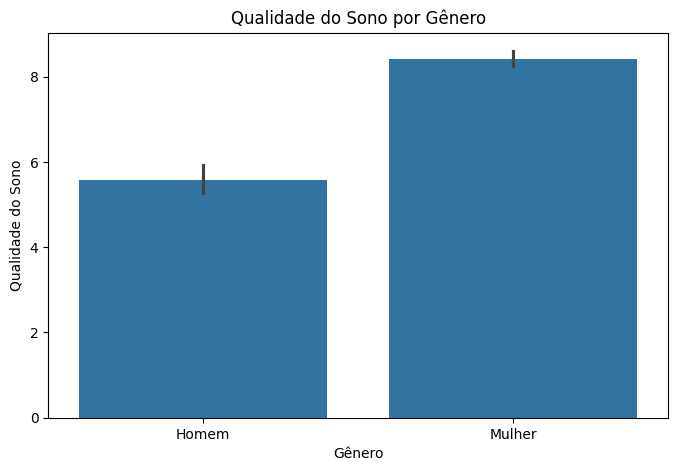

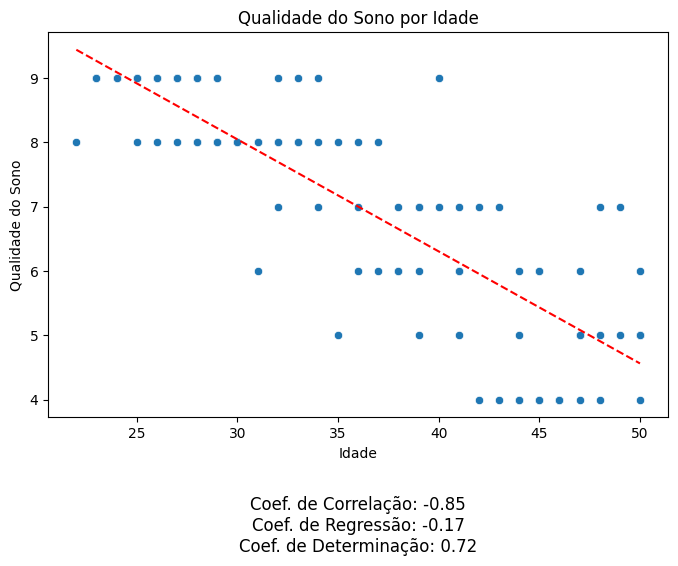

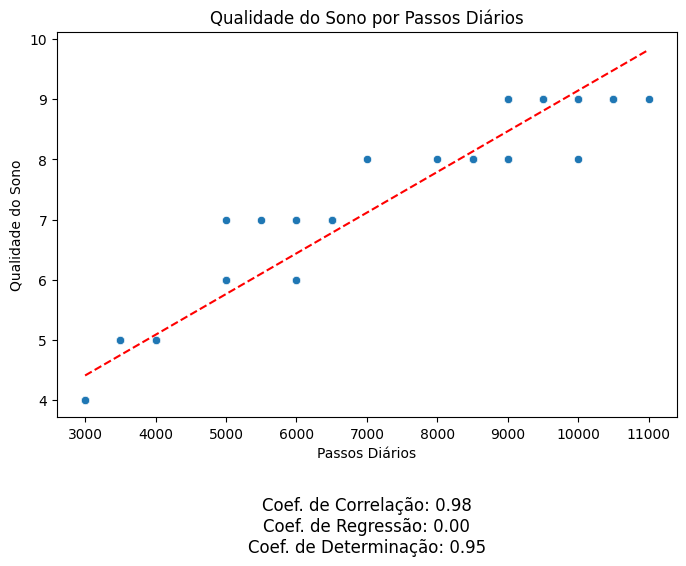

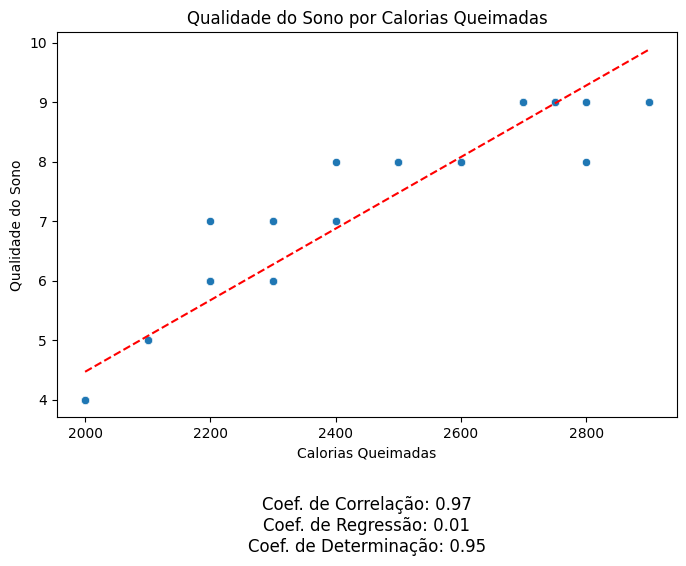

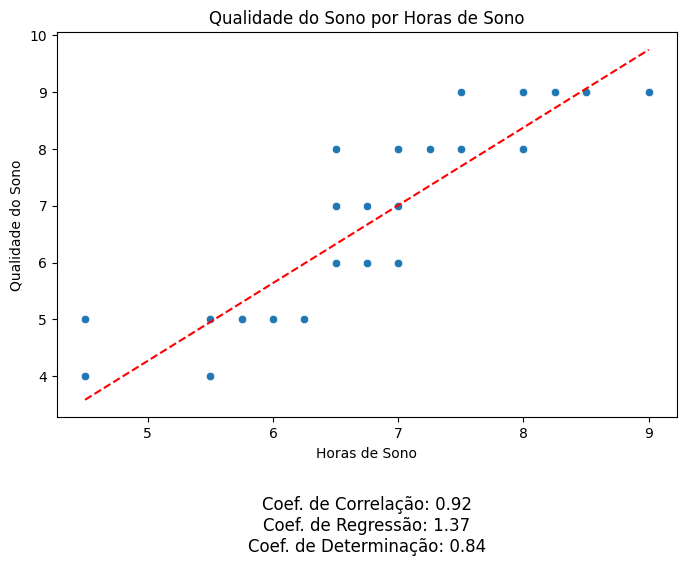

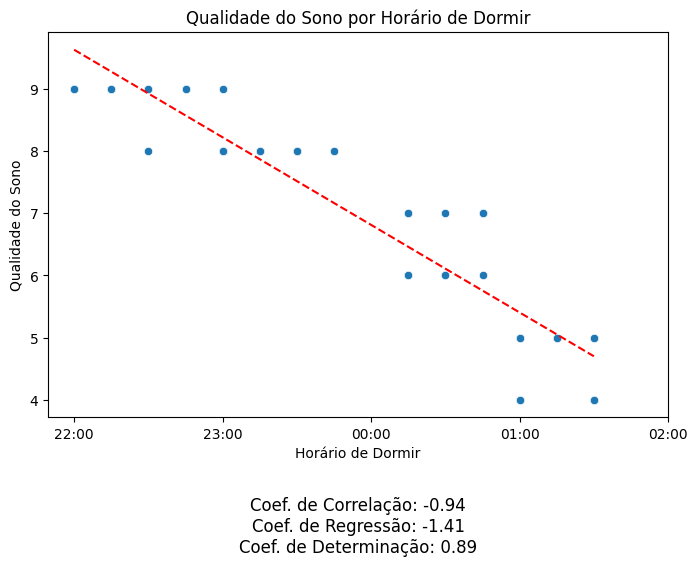

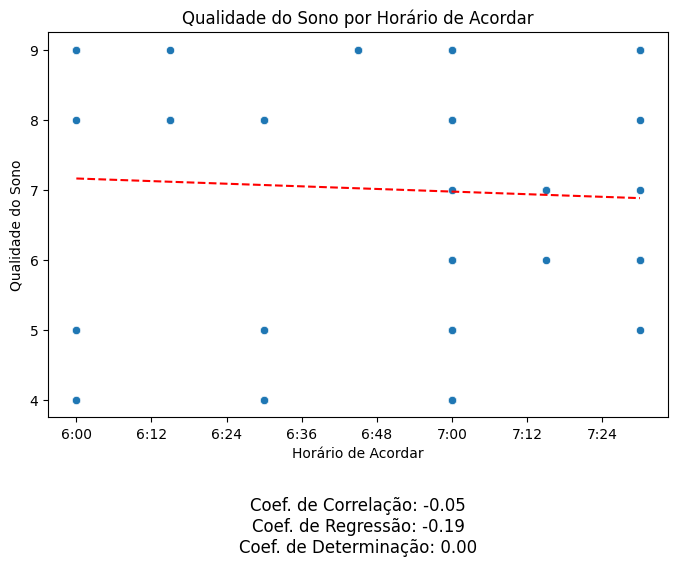

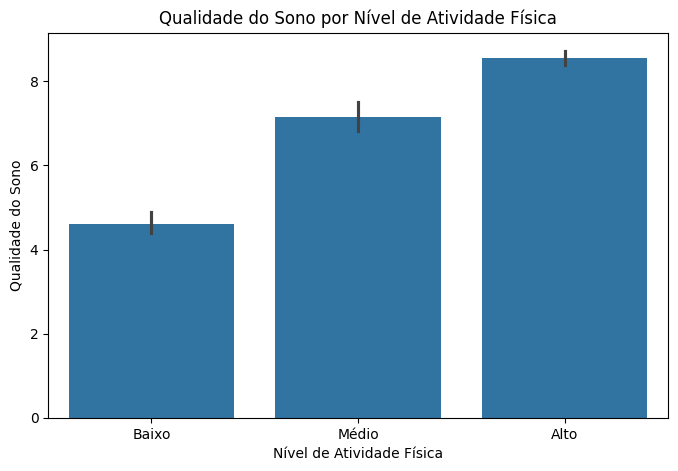

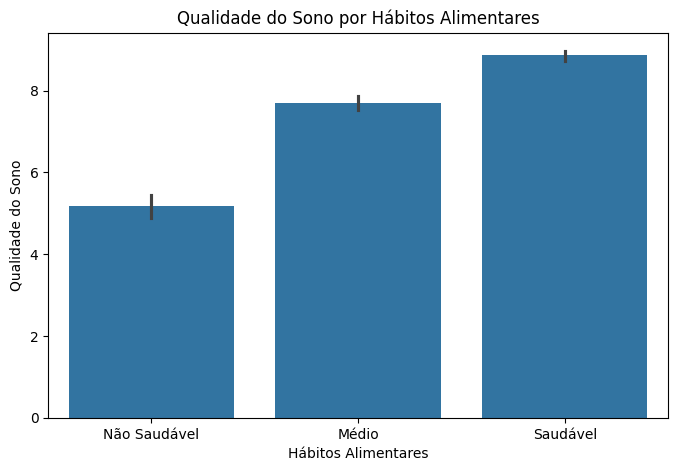

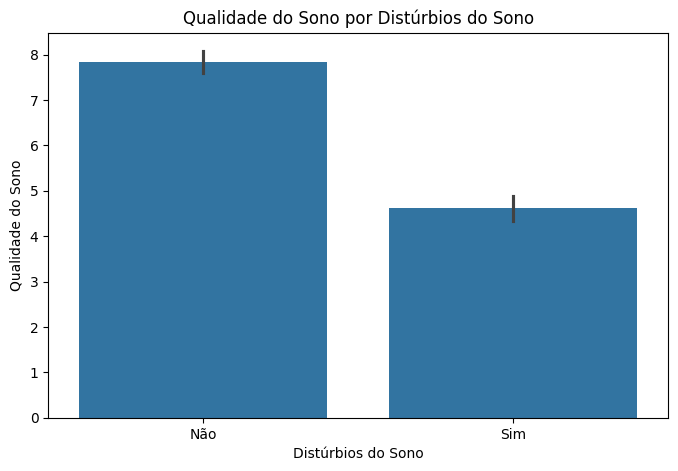

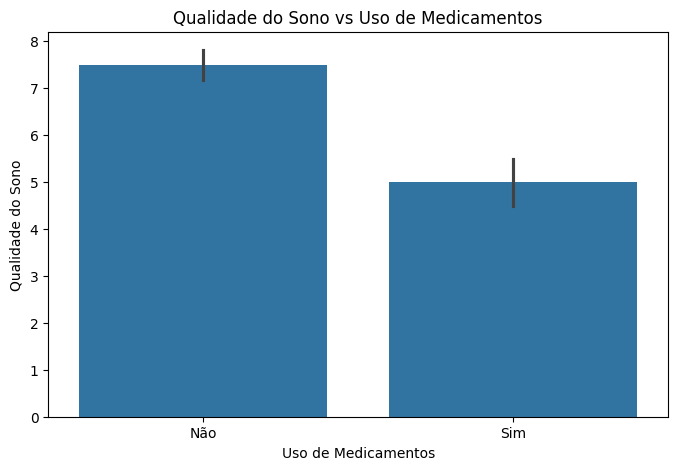

In [81]:
# Gráficos para análise
# Gráfico de Gênero vs Qualidade do Sono
plt.figure(figsize=(8, 5))
sns.barplot(x='Gender', y='Sleep Quality', data=df)
plt.title('Qualidade do Sono por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Qualidade do Sono')
plt.xticks([0, 1], ['Homem', 'Mulher'])
plt.show()

# Gráfico de Idade vs Qualidade do Sono
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(x='Age', y='Sleep Quality', data=df)
plot_regression_line('Age', 'Sleep Quality', df, ax)
plt.title('Qualidade do Sono por Idade')
plt.xlabel('Idade')
plt.ylabel('Qualidade do Sono')
plt.show()

# Gráfico de Passos Diários vs Qualidade do Sono
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(x='Daily Steps', y='Sleep Quality', data=df)
plot_regression_line('Daily Steps', 'Sleep Quality', df, ax)
plt.title('Qualidade do Sono por Passos Diários')
plt.xlabel('Passos Diários')
plt.ylabel('Qualidade do Sono')
plt.show()

# Gráfico de Calorias Queimadas vs Qualidade do Sono
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(x='Calories Burned', y='Sleep Quality', data=df)
plot_regression_line('Calories Burned', 'Sleep Quality', df, ax)
plt.title('Qualidade do Sono por Calorias Queimadas')
plt.xlabel('Calorias Queimadas')
plt.ylabel('Qualidade do Sono')
plt.show()

# Gráfico de Horas de Sono vs Qualidade do Sono
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(x='Hours of Sleep', y='Sleep Quality', data=df)
plot_regression_line('Hours of Sleep', 'Sleep Quality', df, ax)
plt.title('Qualidade do Sono por Horas de Sono')
plt.xlabel('Horas de Sono')
plt.ylabel('Qualidade do Sono')
plt.show()

# Gráfico de Horário de Dormir vs Qualidade do Sono
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(x='Bedtime Adjusted', y='Sleep Quality', data=df)
plot_regression_line('Bedtime Adjusted', 'Sleep Quality', df, ax)
plt.title('Qualidade do Sono por Horário de Dormir')
plt.xlabel('Horário de Dormir')
plt.ylabel('Qualidade do Sono')
plt.xticks([22, 23, 24, 25, 26], ['22:00', '23:00', '00:00', '01:00', '02:00'])
plt.show()

# Gráfico de Horário de Acordar vs Qualidade do Sono
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(x='Wake-up Time Hours', y='Sleep Quality', data=df)
plot_regression_line('Wake-up Time Hours', 'Sleep Quality', df, ax)
plt.title('Qualidade do Sono por Horário de Acordar')
plt.xlabel('Horário de Acordar')
plt.ylabel('Qualidade do Sono')
plt.xticks([6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4], ['6:00', '6:12', '6:24', '6:36', '6:48', '7:00', '7:12', '7:24'])
plt.show()

# Gráfico de Nível de Atividade Física vs Qualidade do Sono
plt.figure(figsize=(8, 5))
sns.barplot(x='Physical Activity Level', y='Sleep Quality', data=df)
plt.title('Qualidade do Sono por Nível de Atividade Física')
plt.xlabel('Nível de Atividade Física')
plt.ylabel('Qualidade do Sono')
plt.xticks([0, 1, 2], ['Baixo', 'Médio', 'Alto'])
plt.show()

# Gráfico de Hábitos Alimentares vs Qualidade do Sono
plt.figure(figsize=(8, 5))
sns.barplot(x='Dietary Habits', y='Sleep Quality', data=df)
plt.title('Qualidade do Sono por Hábitos Alimentares')
plt.xlabel('Hábitos Alimentares')
plt.ylabel('Qualidade do Sono')
plt.xticks([0, 1, 2], ['Não Saudável', 'Médio', 'Saudável'])
plt.show()

# Gráfico de Distúrbios do Sono vs Qualidade do Sono
plt.figure(figsize=(8, 5))
sns.barplot(x='Sleep Disorders', y='Sleep Quality', data=df)
plt.title('Qualidade do Sono por Distúrbios do Sono')
plt.xlabel('Distúrbios do Sono')
plt.ylabel('Qualidade do Sono')
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()

# Gráfico de Uso de Medicamentos vs Qualidade do Sono
plt.figure(figsize=(8, 5))
sns.barplot(x='Medication Usage', y='Sleep Quality', data=df)
plt.title('Qualidade do Sono vs Uso de Medicamentos')
plt.xlabel('Uso de Medicamentos')
plt.ylabel('Qualidade do Sono')
plt.xticks([0, 1], ['Não', 'Sim'])
plt.show()


Coeficientes de Correlação:
               Atributo  Coef. de Correlação
            Daily Steps             0.976277
        Calories Burned             0.973557
         Hours of Sleep             0.918909
         Dietary Habits             0.902498
Physical Activity Level             0.875203
     Wake-up Time Hours            -0.048526
       Medication Usage            -0.579284
        Sleep Disorders            -0.818806
                    Age            -0.848356
       Bedtime Adjusted            -0.941617

Coeficientes de Determinação (R²):
               Atributo  Coef. de Determinação
            Daily Steps               0.953117
        Calories Burned               0.947813
       Bedtime Adjusted               0.886643
         Hours of Sleep               0.844393
         Dietary Habits               0.814502
Physical Activity Level               0.765981
                    Age               0.719708
        Sleep Disorders               0.670443
       Medication 

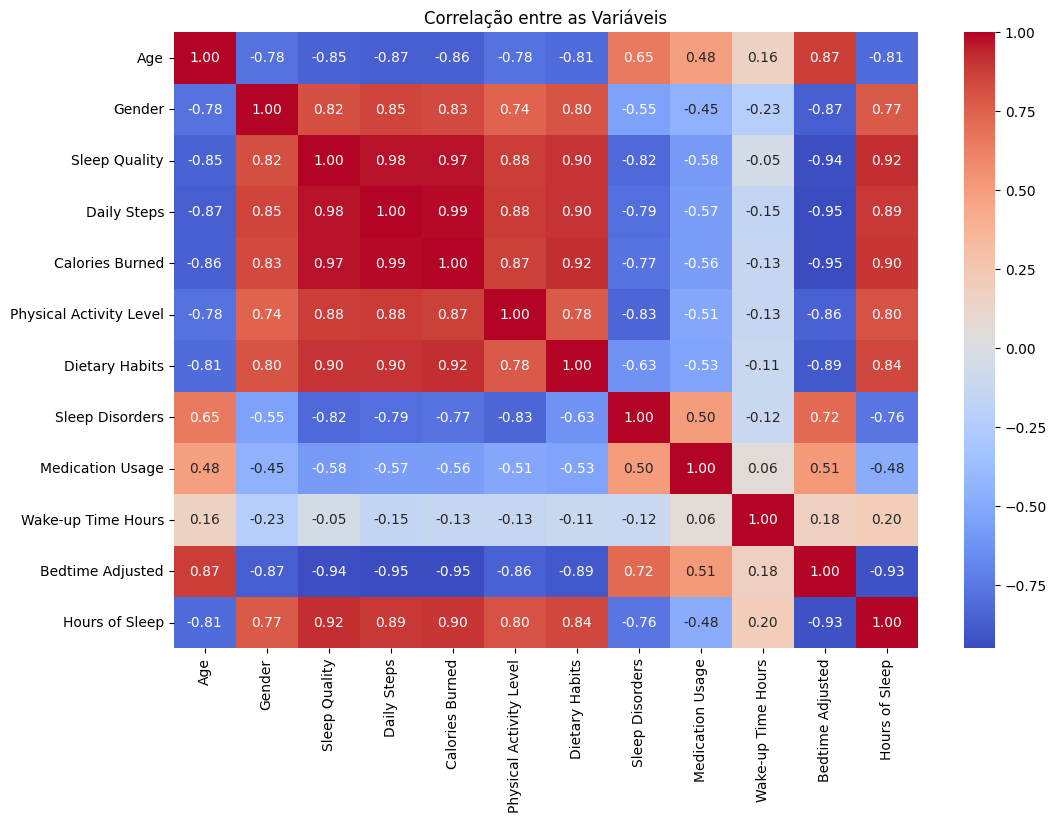

In [82]:
# Análise matemática das relações entre os atributos com a qualidade do sono
# Atributos para análise
attributes = ['Age', 'Daily Steps', 'Calories Burned', 'Hours of Sleep', 'Physical Activity Level', 'Dietary Habits', 'Sleep Disorders', 'Medication Usage', 'Bedtime Adjusted', 'Wake-up Time Hours']

# Calcular coeficientes
correlation_results = []
regression_results = []
determination_results = []
for attr in attributes:
    corr, slope, r_squared = calculate_coefficients(attr, 'Sleep Quality', df)
    correlation_results.append({'Atributo': attr, 'Coef. de Correlação': corr})
    regression_results.append({'Atributo': attr, 'Coef. de Regressão': slope})
    determination_results.append({'Atributo': attr, 'Coef. de Determinação': r_squared})

# Criar DataFrames com os resultados
correlation_df = pd.DataFrame(correlation_results).sort_values(by='Coef. de Correlação', ascending=False)
regression_df = pd.DataFrame(regression_results).sort_values(by='Coef. de Regressão', ascending=False)
determination_df = pd.DataFrame(determination_results).sort_values(by='Coef. de Determinação', ascending=False)

# Exibir as tabelas de resultados sem a numeração de ordem
print("Coeficientes de Correlação:")
print(correlation_df.to_string(index=False))

print("\nCoeficientes de Determinação (R²):")
print(determination_df.to_string(index=False))

print("\nCoeficientes de Regressão (R):")
print(regression_df.to_string(index=False))

# Gráfico de Correlação entre os atributos
df.drop(columns=['User ID'], inplace=True)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre as Variáveis')
plt.show()

### Coeficientes de Correlação
O coeficiente de correlação indicam a força e a direção da relação linear entre cada atributo e a qualidade do sono.

- Daily Steps (0.976) e Calories Burned (0.974): Correlação positiva muito forte. À medida que os passos diários e as calorias queimadas aumentam, a qualidade do sono também aumenta.
- Hours of Sleep (0.919): Correlação positiva forte. Mais horas de sono estão associadas a uma melhor qualidade do sono, portanto:
- Dietary Habits (0.902) e Physical Activity Level (0.875): Correlação positiva forte. Hábitos alimentares saudáveis e níveis mais altos de atividade física estão associados a uma melhor qualidade do sono.
- Wake-up Time Hours (-0.049): Correlação negativa muito fraca. O horário de acordar tem pouca ou nenhuma relação linear com a qualidade do sono.
- Medication Usage (-0.579): Correlação negativa moderada. O uso de medicamentos está associado a uma pior qualidade do sono.
- Sleep Disorders (-0.819) e Age (-0.848): Correlação negativa forte. Distúrbios do sono e idade mais avançada estão associados a uma pior qualidade do sono.
- Bedtime Adjusted (-0.942): Correlação negativa muito forte. Dormir mais tarde está associado a uma pior qualidade do sono.

### Coeficientes de Determinação (R²)
O coeficiente de determinação indicam a proporção da variabilidade na qualidade do sono que é explicada por cada atributo, portanto:

- Daily Steps (0.953) e Calories Burned (0.948): Esses atributos explicam aproximadamente 95% e 94% da variabilidade na qualidade do sono, respectivamente.
- Bedtime Adjusted (0.887) e Hours of Sleep (0.844): Dormir mais cedo e mais horas de sono explicam uma grande parte da variabilidade na qualidade do sono.
- Dietary Habits (0.815) e Physical Activity Level (0.766): Hábitos alimentares saudáveis e níveis de atividade física explicam uma parte significativa da variabilidade na qualidade do sono.
- Age (0.720) e Sleep Disorders (0.670): A idade e os distúrbios do sono explicam uma parte considerável da variabilidade na qualidade do sono.
- Medication Usage (0.336): O uso de medicamentos explica uma parte menor da variabilidade na qualidade do sono.
- Wake-up Time Hours (0.002): O horário de acordar explica quase nada da variabilidade na qualidade do sono.

### Coeficientes de Regressão
Os coeficientes de regressão indicam a mudança esperada na qualidade do sono para cada unidade de mudança em cada atributo, portanto:

- Physical Activity Level (1.934) e Dietary Habits (1.882): Aumentar o nível de atividade física e melhorar os hábitos alimentares têm um impacto positivo significativo na qualidade do sono.
- Hours of Sleep (1.369): Cada hora adicional de sono melhora significativamente a qualidade do sono.
- Calories Burned (0.006) e Daily Steps (0.001): Aumentar as calorias queimadas e os passos diários tem um impacto positivo, mas menor, na qualidade do sono.
- Age (-0.174) e Wake-up Time Hours (-0.187): A idade e acordar mais tarde têm um impacto negativo na qualidade do sono.
- Bedtime Adjusted (-1.409): Dormir mais tarde tem um impacto negativo significativo na qualidade do sono.
- Medication Usage (-2.500) e Sleep Disorders (-3.222): O uso de medicamentos e distúrbios do sono têm um impacto negativo muito significativo na qualidade do sono.

## Conclusões
#### - Atributos Positivos:

Passos Diários, Calorias Queimadas, Horas de Sono, Hábitos Alimentares Saudáveis e Nível de Atividade Física estão fortemente correlacionados com uma melhor qualidade do sono e explicam uma grande parte da variabilidade na qualidade do sono.
#### - Atributos Negativos:

Distúrbios do Sono, Idade, Uso de Medicamentos e Dormir Tarde estão fortemente correlacionados com uma pior qualidade do sono e explicam uma parte significativa da variabilidade na qualidade do sono.
#### - Impacto Menor:

Horário de Acordar tem pouca ou nenhuma relação linear com a qualidade do sono e explica quase nada da variabilidade na qualidade do sono.

# Criar os Modelos

In [83]:
# Preparar os dados para os modelos
# Selecionar as colunas para o treinamento
features = ['Age', 'Gender', 'Daily Steps', 'Calories Burned', 'Hours of Sleep', 'Physical Activity Level', 'Dietary Habits', 'Sleep Disorders', 'Medication Usage', 'Bedtime Adjusted']
x = df[features]
y = df['Sleep Quality']

# Dividir os dados em conjuntos de Treino, Validação e Teste para a MLP
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Exibir as dimensões dos conjuntos
print("\nDimensões dos conjuntos do MLP (Sem One-Hot):")
print("Treino:", X_train.shape, y_train.shape)
print("Validação:", X_val.shape, y_val.shape)
print("Teste:", X_test.shape, y_test.shape)
print("\n")

# Normalizar as variáveis numéricas
numerical_features = ['Age', 'Daily Steps', 'Calories Burned', 'Bedtime Adjusted', 'Hours of Sleep']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Aplicar One-Hot Encoding nas variáveis categóricas
categorical_cols = ['Physical Activity Level', 'Dietary Habits', 'Sleep Disorders', 'Medication Usage', 'Gender']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Alinhar as colunas, preenchendo com zeros caso alguma categoria esteja ausente
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Exibir as dimensões dos conjuntos
print("\nDimensões dos conjuntos do MLP (Com One-Hot):")
print("Treino:", X_train.shape, y_train.shape)
print("Validação:", X_val.shape, y_val.shape)
print("Teste:", X_test.shape, y_test.shape)
print("\n")

# Dividir os dados em conjuntos de Treino, Validação e Teste para o CatBoost
X_train_cat, X_temp_cat, y_train_cat, y_temp_cat = train_test_split(x, y, test_size=0.30, random_state=42)
X_val_cat, X_test_cat, y_val_cat, y_test_cat = train_test_split(X_temp_cat, y_temp_cat, test_size=0.50, random_state=42)

# Exibir as dimensões dos conjuntos
print("\nDimensões dos conjuntos do CatBoost:")
print("Treino:", X_train_cat.shape, y_train_cat.shape)
print("Validação:", X_val_cat.shape, y_val_cat.shape)
print("Teste:", X_test_cat.shape, y_test_cat.shape)
print("\n")

# Identificar as colunas categóricas
categorical_cols = ['Sleep Disorders', 'Medication Usage', 'Gender', 'Dietary Habits', 'Physical Activity Level']

# Reconverter essas colunas para string para que o CatBoost as reconheça como categóricas
for col in categorical_cols:
    X_train_cat[col] = X_train_cat[col].astype(str)
    X_val_cat[col] = X_val_cat[col].astype(str)
    X_test_cat[col] = X_test_cat[col].astype(str)

# Obter os índices das colunas categóricas
cat_features_indices = [X_train_cat.columns.get_loc(col) for col in categorical_cols]


Dimensões dos conjuntos do MLP (Sem One-Hot):
Treino: (70, 10) (70,)
Validação: (15, 10) (15,)
Teste: (15, 10) (15,)



Dimensões dos conjuntos do MLP (Com One-Hot):
Treino: (70, 12) (70,)
Validação: (15, 12) (15,)
Teste: (15, 12) (15,)



Dimensões dos conjuntos do CatBoost:
Treino: (70, 10) (70,)
Validação: (15, 10) (15,)
Teste: (15, 10) (15,)




## MLP

In [84]:
# Definir os hiperparâmetros para ajuste
param_grid = {
    'hidden_layer_sizes': [(25, 50), (50, 25), (50, 50), (100, 50), (50, 100), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'max_iter': [500, 750, 1000]
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(MLPRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Ajustar o modelo
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=750, solver=adam; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=lbfgs; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=lbfgs; total time=   0.3s
[CV] END activati

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=750, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=750, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=750, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50), max_i

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=lbfgs; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=lbfgs; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=1

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=500, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=500, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=500, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=500, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=750, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=750, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=75

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100), max_iter=750, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100), max_iter=750, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100), max_iter=750, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100), max_iter=750, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100), max_iter=750, solver=lbfgs; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100), max_iter=750, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=500, solver=adam; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100), m

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=500, solver=lbfgs; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=500, solver=lbfgs; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=500, solver=

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, solver=adam; total time=   0.4s[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=sgd; total time=   0.2s

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, solver=lbfgs; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, so

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, solver=lbfgs; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=lbfgs; total time=   0.6s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=lbfgs; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=lbfgs; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=lbfgs; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=lbfgs; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=lbfgs; total time=   0.7s[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, sol

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, solver=lbfgs; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, solver=lbfgs; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=adam; total time=   0.3s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multi

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=1000, solver=lbfgs; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=1000, solver=lbfgs; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=lbfgs; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=1000, solver=lbfgs; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=adam; total time=   0.3s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=lbfgs; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=lbfgs; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000, solv

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=lbfgs; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=lbfgs; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=adam; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=sgd; total time=   0.3s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=lbfgs; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=lbfgs; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=adam; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=lbfgs; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_i

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=500, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=lbfgs; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=lbfgs; total time=   1.1s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=lbfgs; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=750, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=750, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=750, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=750, solver=sgd; total time=   0.2s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=500, solver=lbfgs; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=500, solver=lbfgs; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=lbfgs; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=500, solver=lbfgs; total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=750, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=lbfgs; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=750, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=1000, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), max_it

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=adam; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=750, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=750, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=750, solver=adam; total time=   0.6s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=500, solver=lbfgs; total time=   1.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=adam; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=500, solver=lbfgs; total time=   1.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=sgd; total time=   0.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), m

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=lbfgs; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=750, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=750, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=500, solver=lbfgs; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=750, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=750

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=500, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=500, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=lbfgs; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=500, solver=lbfgs; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=750, solver=lbfgs; total time=   2.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=500, solver=adam; total time=   0.3s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=500, solver=lbfgs; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=500, solver=lbfgs; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=lbfgs; total time=   1.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=750, solver=lbfgs; total time=   0.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter=500, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25), max_iter

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), max_iter=500, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), max_iter=500, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=adam; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), max_iter=500, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=lbfgs; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=lbfgs; total time=   2.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), max_iter=750, solver=lbfgs; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), max

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=500, solver=lbfgs; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=500, solver=lbfgs; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=500, solver=lbfgs; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=750, solver=lbfgs; total time=   1.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=lbfgs; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=lbfgs; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=lbfgs; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=500, solver=lbfgs; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50), max_iter=1000, solver=lbfgs; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=1000, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=1000, 

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, solver=lbfgs; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, solver=lbfgs; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25), max_iter=750, solv

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=adam; total time=   0.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=adam; total time=   0.3s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=lbfgs; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=adam; total time=   0.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=750, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=lbfgs; total time=   0.9s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=750, solver=lbfgs; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=lbfgs; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs; total time=   0.7s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500, solver=lbfgs; total time=   0.7s[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=sgd; total time=   0.0s

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=lbfgs; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=1000, solver=lbfgs; total time=   1.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=500, solver=adam; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=500, solver=adam; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=1000, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), max_it

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=500, solver=adam; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=500, solver=lbfgs; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=500, solver=lbfgs; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=500, solver=lbfgs; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=500, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=500, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=500, solver=adam; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=500, solver=adam; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=750, solver=lbfgs; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=750, solver=lbfgs; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=750, solver=lbfgs; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=adam; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=adam; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=adam; total time=   0.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100),

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=500, solver=lbfgs; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=500, solver=lbfgs; total time=   1.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=500, solver=lbfgs; total time=   1.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=1000, solver=lbfgs; total time=   1.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=1000, solver=lbfgs; total time=   1.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), max_iter=1000, solver=lbfgs; total time=   1.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=750, solver=lbfgs; total time=   1.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=750, solver=lbfgs; total time=   1.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 

/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=lbfgs; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=lbfgs; total time=   1.6s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=1000, solver=lbfgs; total time=   1.8s


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=3, estimator=MLPRegressor(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(25, 50), (50, 25), (50, 50),
                                                (100, 50), (50, 100),
                                                (100, 100)],
                         'max_iter': [500, 750, 1000],
                         'solver': ['adam', 'sgd', 'lbfgs']},
             scoring='neg_mean_squared_error', verbose=2)

In [85]:
# Imprimir os melhores hiperparâmetros
print("\nHiperparâmetros otimizados:")
print(grid_search.best_params_)

# Função de treino e avaliação
def train_and_evaluate_mlp(X_train, y_train, X_val, y_val):
    mlp_model = grid_search.best_estimator_
    mlp_model.fit(X_train, y_train)
    y_val_pred_mlp = mlp_model.predict(X_val)
    rmse_mlp = np.sqrt(mean_squared_error(y_val, y_val_pred_mlp))
    r2_mlp = r2_score(y_val, y_val_pred_mlp)
    importances = np.abs(mlp_model.coefs_[0]).sum(axis=1)
    feature_importances_mlp = pd.Series(importances, index=X_train.columns)
    return rmse_mlp, r2_mlp, y_val_pred_mlp, feature_importances_mlp

# Resultados do treinamento
rmse_mlp, r2_mlp, y_val_pred_mlp, feature_importances_mlp = train_and_evaluate_mlp(X_train, y_train, X_val, y_val)


Hiperparâmetros otimizados:
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'max_iter': 500, 'solver': 'lbfgs'}


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



MLP - RMSE na validação: 0.19
MLP - R² na validação: 0.98


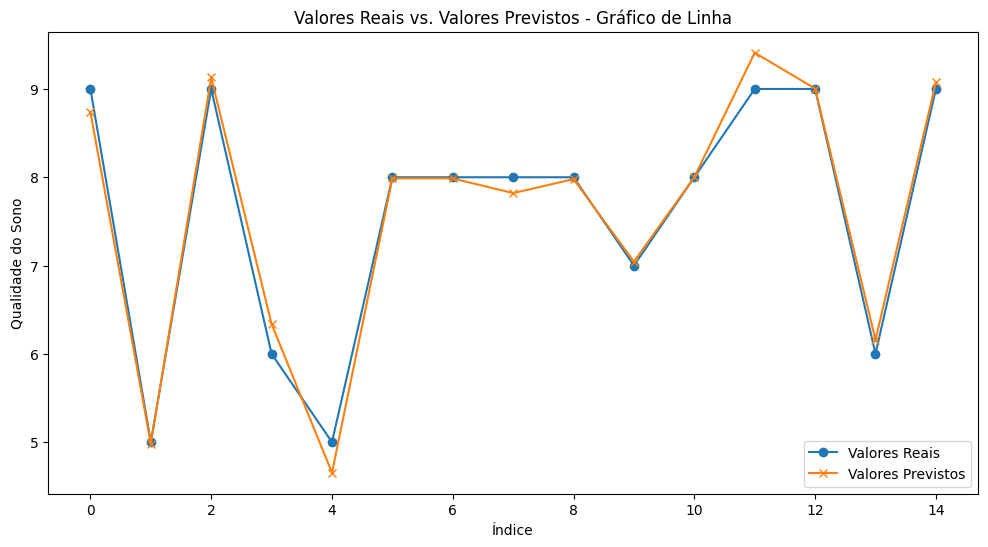

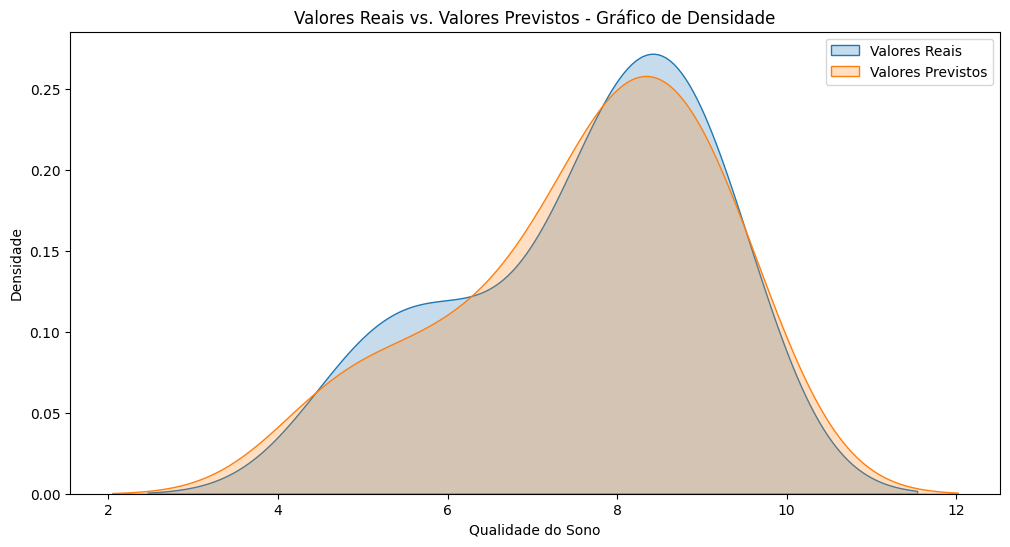

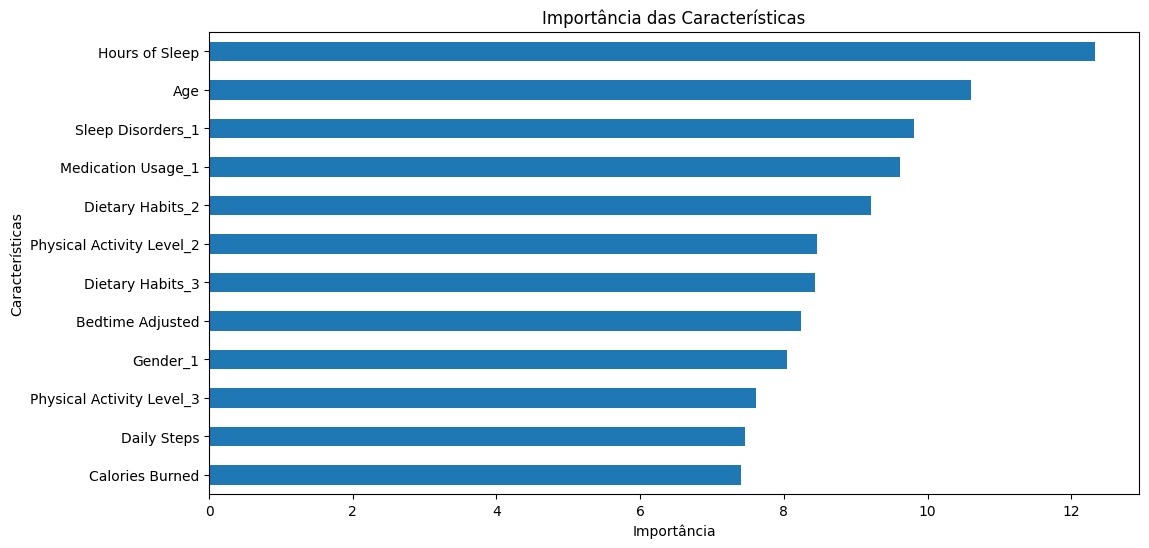

In [86]:
# Resultados do treinamento
print(f'\nMLP - RMSE na validação: {rmse_mlp:.2f}')
print(f'MLP - R² na validação: {r2_mlp:.2f}')

# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(y_val.values, label='Valores Reais', marker='o')
plt.plot(y_val_pred_mlp, label='Valores Previstos', marker='x')
plt.title('Valores Reais vs. Valores Previstos - Gráfico de Linha')
plt.xlabel('Índice')
plt.ylabel('Qualidade do Sono')
plt.legend()
plt.show()

# Gráfico de Densidade
plt.figure(figsize=(12, 6))
sns.kdeplot(y_val, label='Valores Reais', fill=True)
sns.kdeplot(y_val_pred_mlp, label='Valores Previstos', fill=True)
plt.title('Valores Reais vs. Valores Previstos - Gráfico de Densidade')
plt.xlabel('Qualidade do Sono')
plt.ylabel('Densidade')
plt.legend()
plt.show()

# Gráfico de Importância das Características
plt.figure(figsize=(12, 6))
feature_importances_mlp.sort_values().plot(kind='barh')
plt.title('Importância das Características')
plt.xlabel('Importância')
plt.ylabel('Características')
plt.show()

## CatBoost

In [87]:
# Modelo inicial
cat_model_init = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=10,
    random_seed=42
)

# Treinamento inicial
cat_model_init.fit(X_train_cat, y_train_cat, cat_features=cat_features_indices, eval_set=(X_val_cat, y_val_cat))

0:	learn: 1.6359724	test: 1.4384152	best: 1.4384152 (0)	total: 2.12ms	remaining: 210ms
10:	learn: 0.7812317	test: 0.7373933	best: 0.7373933 (10)	total: 9.8ms	remaining: 79.3ms
20:	learn: 0.4209884	test: 0.4517782	best: 0.4517782 (20)	total: 15.9ms	remaining: 59.8ms
30:	learn: 0.2740221	test: 0.3380314	best: 0.3380314 (30)	total: 21.7ms	remaining: 48.3ms
40:	learn: 0.2131031	test: 0.3031410	best: 0.3031410 (40)	total: 26ms	remaining: 37.5ms
50:	learn: 0.1791993	test: 0.2914270	best: 0.2910951 (48)	total: 30.4ms	remaining: 29.2ms
60:	learn: 0.1606965	test: 0.2846127	best: 0.2846127 (60)	total: 34.4ms	remaining: 22ms
70:	learn: 0.1442706	test: 0.2798282	best: 0.2798282 (70)	total: 38.5ms	remaining: 15.7ms
80:	learn: 0.1323703	test: 0.2796284	best: 0.2796284 (80)	total: 43.1ms	remaining: 10.1ms
90:	learn: 0.1152418	test: 0.2784883	best: 0.2784662 (86)	total: 46.9ms	remaining: 4.63ms
99:	learn: 0.0970414	test: 0.2793218	best: 0.2772035 (94)	total: 51.3ms	remaining: 0us

bestTest = 0.2772034

In [88]:
# Função de treinamento do CatBoost
def train_and_evaluate_catboost(X_train, y_train, X_val, y_val):
    categorical_cols = ['Sleep Disorders', 'Medication Usage', 'Gender', 'Dietary Habits', 'Physical Activity Level']
    for col in categorical_cols:
        X_train[col] = X_train[col].astype(str)
        X_val[col] = X_val[col].astype(str)
    cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]
    cat_model = CatBoostRegressor(iterations=cat_model_init.get_best_iteration(), learning_rate=0.1, depth=6, loss_function='RMSE', verbose=10, random_seed=42)
    cat_model.fit(X_train, y_train, cat_features=cat_features_indices)
    y_val_pred_catboost = cat_model.predict(X_val)
    rmse_catboost = np.sqrt(mean_squared_error(y_val, y_val_pred_catboost))
    r2_catboost = r2_score(y_val, y_val_pred_catboost)
    feature_importances_cat = cat_model.get_feature_importance()
    return rmse_catboost, r2_catboost, y_val_pred_catboost, feature_importances_cat

# Resultados do treinamento
rmse_cat, r2_cat, y_val_pred_cat, feature_importances_cat = train_and_evaluate_catboost(X_train_cat, y_train_cat, X_val_cat, y_val_cat)

0:	learn: 1.6359724	total: 2.21ms	remaining: 205ms
10:	learn: 0.7812317	total: 10.5ms	remaining: 79.4ms
20:	learn: 0.4209884	total: 15.4ms	remaining: 53.7ms
30:	learn: 0.2740221	total: 21.2ms	remaining: 43ms
40:	learn: 0.2131031	total: 25.4ms	remaining: 32.8ms
50:	learn: 0.1791993	total: 30.4ms	remaining: 25.6ms
60:	learn: 0.1606965	total: 35.6ms	remaining: 19.3ms
70:	learn: 0.1442706	total: 40.7ms	remaining: 13.2ms
80:	learn: 0.1323703	total: 46.1ms	remaining: 7.41ms
90:	learn: 0.1152418	total: 51.8ms	remaining: 1.71ms
93:	learn: 0.1088206	total: 53ms	remaining: 0us



MLP - RMSE na validação: 0.28
MLP - R² na validação: 0.96


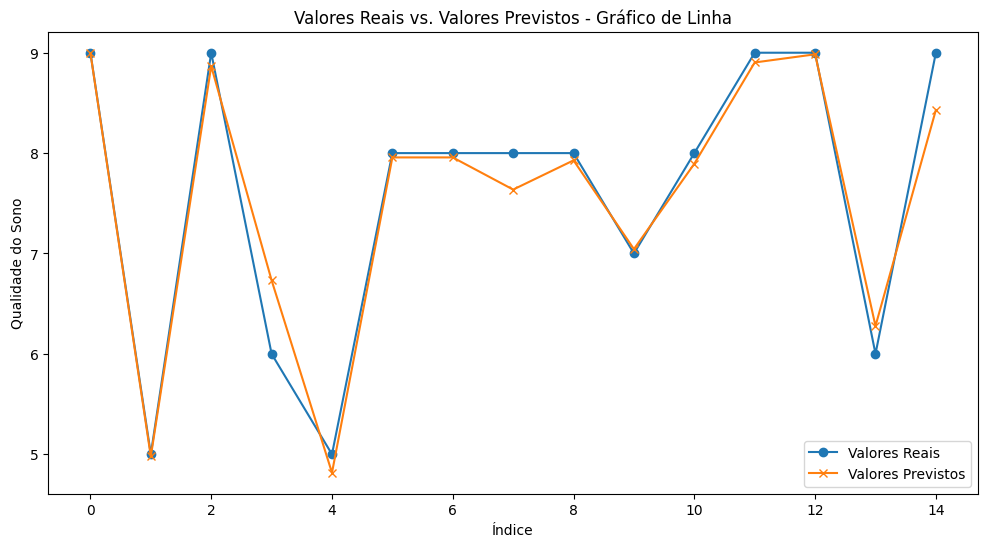

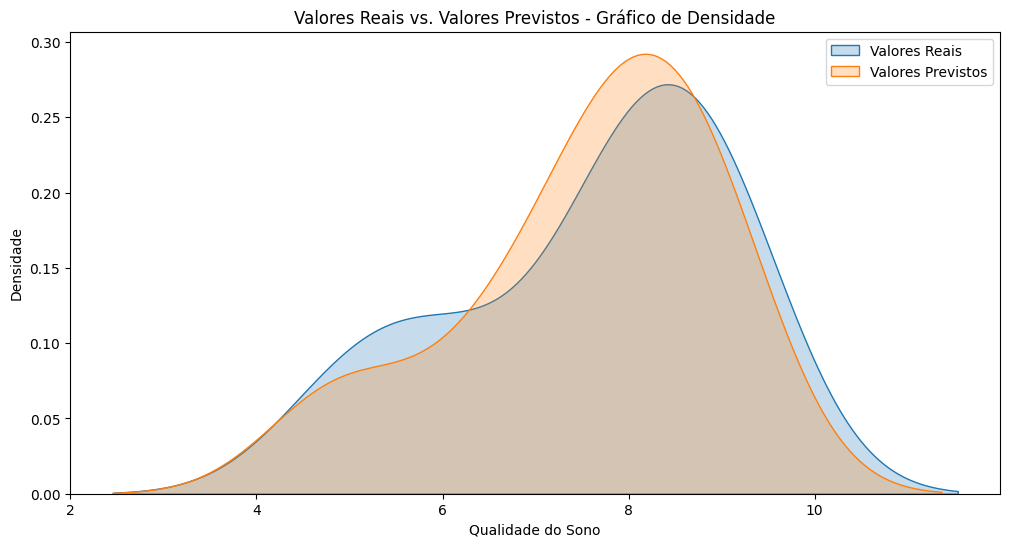

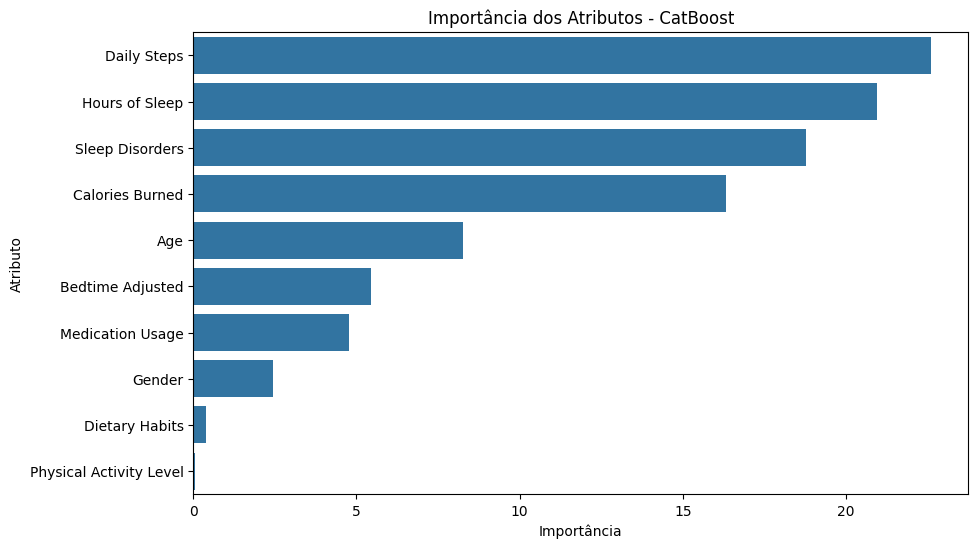

In [89]:
# Imprimir resultados do treinamento
print(f'\nMLP - RMSE na validação: {rmse_cat:.2f}')
print(f'MLP - R² na validação: {r2_cat:.2f}')

# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(y_val.values, label='Valores Reais', marker='o')
plt.plot(y_val_pred_cat, label='Valores Previstos', marker='x')
plt.title('Valores Reais vs. Valores Previstos - Gráfico de Linha')
plt.xlabel('Índice')
plt.ylabel('Qualidade do Sono')
plt.legend()
plt.show()

# Gráfico de Densidade
plt.figure(figsize=(12, 6))
sns.kdeplot(y_val, label='Valores Reais', fill=True)
sns.kdeplot(y_val_pred_cat, label='Valores Previstos', fill=True)
plt.title('Valores Reais vs. Valores Previstos - Gráfico de Densidade')
plt.xlabel('Qualidade do Sono')
plt.ylabel('Densidade')
plt.legend()
plt.show()

# Gráfico de Importância das Características
feature_names = X_train_cat.columns
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_cat})
fi_df = fi_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Importância dos Atributos - CatBoost')
plt.xlabel('Importância')
plt.ylabel('Atributo')
plt.show()

## Validação


In [90]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para armazenar os resultados
results_mlp = []
results_catboost = []
predictions_mlp = []
predictions_catboost = []

# Loop de validação cruzada
for train_index, val_index in kf.split(x):
    X_train, X_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # MLP
    rmse_mlp, r2_mlp, y_pred_mlp, importances_mlp = train_and_evaluate_mlp(X_train, y_train, X_val, y_val)
    results_mlp.append((rmse_mlp, r2_mlp))
    predictions_mlp.append((y_val, y_pred_mlp))

    # CatBoost
    rmse_catboost, r2_catboost, y_pred_cat, importances_cat = train_and_evaluate_catboost(X_train, y_train, X_val, y_val)
    results_catboost.append((rmse_catboost, r2_catboost))
    predictions_catboost.append((y_val, y_pred_cat))

/tmp/ipykernel_893/941605292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype(str)
/tmp/ipykernel_893/941605292.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = X_val[col].astype(str)
/tmp/ipykernel_893/941605292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

0:	learn: 1.5749381	total: 722us	remaining: 67.2ms
10:	learn: 0.7488743	total: 6.91ms	remaining: 52.1ms
20:	learn: 0.3991755	total: 29.9ms	remaining: 104ms
30:	learn: 0.2636390	total: 42.6ms	remaining: 86.6ms
40:	learn: 0.2055068	total: 45.3ms	remaining: 58.5ms
50:	learn: 0.1695296	total: 50.2ms	remaining: 42.4ms
60:	learn: 0.1440701	total: 54.7ms	remaining: 29.6ms
70:	learn: 0.1301057	total: 59.6ms	remaining: 19.3ms
80:	learn: 0.1126208	total: 64.1ms	remaining: 10.3ms
90:	learn: 0.1023686	total: 69.3ms	remaining: 2.29ms
93:	learn: 0.0997708	total: 70.6ms	remaining: 0us


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/tmp/ipykernel_893/941605292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype(str)
/tmp/ipykernel_893/941605292.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

0:	learn: 1.6351973	total: 654us	remaining: 60.8ms
10:	learn: 0.7619962	total: 26.3ms	remaining: 199ms
20:	learn: 0.3945210	total: 40.8ms	remaining: 142ms
30:	learn: 0.2364189	total: 46.2ms	remaining: 93.8ms
40:	learn: 0.1715666	total: 49.7ms	remaining: 64.2ms
50:	learn: 0.1401693	total: 53.9ms	remaining: 45.4ms
60:	learn: 0.1215504	total: 60.8ms	remaining: 32.9ms
70:	learn: 0.1091449	total: 65.4ms	remaining: 21.2ms
80:	learn: 0.1006214	total: 70.3ms	remaining: 11.3ms
90:	learn: 0.0920118	total: 77.5ms	remaining: 2.55ms
93:	learn: 0.0889811	total: 79.4ms	remaining: 0us


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/tmp/ipykernel_893/941605292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype(str)
/tmp/ipykernel_893/941605292.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

0:	learn: 1.5036917	total: 833us	remaining: 77.6ms
10:	learn: 0.7242320	total: 22.1ms	remaining: 167ms
20:	learn: 0.3911440	total: 25.2ms	remaining: 87.6ms
30:	learn: 0.2608304	total: 28.6ms	remaining: 58ms
40:	learn: 0.1978423	total: 35.6ms	remaining: 46ms
50:	learn: 0.1634016	total: 38.3ms	remaining: 32.3ms
60:	learn: 0.1424136	total: 42.6ms	remaining: 23ms
70:	learn: 0.1203096	total: 47ms	remaining: 15.2ms
80:	learn: 0.1058920	total: 50.9ms	remaining: 8.17ms
90:	learn: 0.0934098	total: 55.4ms	remaining: 1.83ms
93:	learn: 0.0893805	total: 56.8ms	remaining: 0us


/home/saposopa/Saparia/IAP/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/tmp/ipykernel_893/941605292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype(str)
/tmp/ipykernel_893/941605292.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

0:	learn: 1.5842193	total: 490us	remaining: 45.7ms
10:	learn: 0.7662834	total: 4.93ms	remaining: 37.2ms
20:	learn: 0.4193197	total: 9.58ms	remaining: 33.3ms
30:	learn: 0.2769589	total: 36.8ms	remaining: 74.7ms
40:	learn: 0.2129486	total: 50.9ms	remaining: 65.8ms
50:	learn: 0.1735393	total: 55.2ms	remaining: 46.5ms
60:	learn: 0.1538491	total: 58.4ms	remaining: 31.6ms
70:	learn: 0.1440053	total: 61.3ms	remaining: 19.9ms
80:	learn: 0.1326659	total: 65ms	remaining: 10.4ms
90:	learn: 0.1169845	total: 68.9ms	remaining: 2.27ms
93:	learn: 0.1130580	total: 70.3ms	remaining: 0us
0:	learn: 1.6533554	total: 601us	remaining: 56ms
10:	learn: 0.7830961	total: 5.21ms	remaining: 39.3ms
20:	learn: 0.4122671	total: 11.1ms	remaining: 38.6ms
30:	learn: 0.2478773	total: 15.1ms	remaining: 30.7ms
40:	learn: 0.1849513	total: 38.5ms	remaining: 49.7ms
50:	learn: 0.1437843	total: 50.2ms	remaining: 42.3ms
60:	learn: 0.1217434	total: 56.6ms	remaining: 30.6ms
70:	learn: 0.1073373	total: 61.6ms	remaining: 20ms
80:	le

/tmp/ipykernel_893/941605292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype(str)
/tmp/ipykernel_893/941605292.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = X_val[col].astype(str)
/tmp/ipykernel_893/941605292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [91]:
# Exibir os resultados
print("\nResultados da Validação Cruzada - MLP:")
rmse_mlp_values = []
r2_mlp_values = []
for i, (rmse, r2) in enumerate(results_mlp):
    print(f'Fold {i+1} - RMSE: {rmse:.2f}, R²: {r2:.2f}')
    rmse_mlp_values.append(rmse)
    r2_mlp_values.append(r2)

print(f'\nValidação Cruzada - RMSE médio: {np.mean(rmse_mlp_values):.2f} ± {np.std(rmse_mlp_values):.2f}')
print(f'Validação Cruzada - R² médio: {np.mean(r2_mlp_values):.2f} ± {np.std(r2_mlp_values):.2f}')

print("\nResultados da Validação Cruzada - CatBoost:")
rmse_catboost_values = []
r2_catboost_values = []
for i, (rmse, r2) in enumerate(results_catboost):
    print(f'Fold {i+1} - RMSE: {rmse:.2f}, R²: {r2:.2f}')
    rmse_catboost_values.append(rmse)
    r2_catboost_values.append(r2)

print(f'\nValidação Cruzada - RMSE médio: {np.mean(rmse_catboost_values):.2f} ± {np.std(rmse_catboost_values):.2f}')
print(f'Validação Cruzada - R² médio: {np.mean(r2_catboost_values):.2f} ± {np.std(r2_catboost_values):.2f}')


Resultados da Validação Cruzada - MLP:
Fold 1 - RMSE: 0.35, R²: 0.96
Fold 2 - RMSE: 0.48, R²: 0.90
Fold 3 - RMSE: 0.20, R²: 0.99
Fold 4 - RMSE: 0.28, R²: 0.98
Fold 5 - RMSE: 0.38, R²: 0.92

Validação Cruzada - RMSE médio: 0.34 ± 0.09
Validação Cruzada - R² médio: 0.95 ± 0.03

Resultados da Validação Cruzada - CatBoost:
Fold 1 - RMSE: 0.21, R²: 0.99
Fold 2 - RMSE: 0.37, R²: 0.94
Fold 3 - RMSE: 0.21, R²: 0.99
Fold 4 - RMSE: 0.15, R²: 0.99
Fold 5 - RMSE: 0.44, R²: 0.90

Validação Cruzada - RMSE médio: 0.28 ± 0.11
Validação Cruzada - R² médio: 0.96 ± 0.04
